# Click to Conversion

# Introduction
The purpose of this project is to build a neural network to predict visitor conversion of a business webpage. This will be completed in several steps:
   1. Data Cleaning - Nan items will be filled, and outliers will be transformed
   2. Data Exploration - The data will be analyzed to understand the relationships within the dataset
   3. Unsupervised Learning Clusters - Clustering untrained data will be used to identify user relationships
   4. Neural Network Modeling - Keras will be implemented to determine if revenue can be predicted

# Importing and Data Cleaning
The dataset was obtained from Kaggle.com (Data). It consists of website traffic data of 12,330 visits over the course of a year. The dataset did not specify the company or type of industry this website operates in. For the purpose of this project, it will be assumed that the website is a retail website.

The dataset is comprised of 10 numerical and 8 categorical values. This data includes three webpage categories, administrative, informational, and product related. The user-visit duration for each category of webpage was recorded in the duration column for that category. 'Bounce Rates', 'Exit Rates' and 'Page Value' were calculated by google analytics for each page and visit, and were also recorded in their respective columns. 

The bounce rate is the rate at which a user enters a webpage and leaves the website from that page, without going to any further webpages. The exit rate is the rate at which the user leaves the website after visiting one or multiple pages, multiple page visits are factored into the exit rate calculation. Page value is the rate at which a given page contributes to revenue.

The remaining variables pertain to the demographics of the users and timeframe: special day, month, operating system, browser, region, etc. These variables will be explored below to find correlations with revenue. Furthermore, the data will be inspected for outliers and cleaned below.


In [1]:
# Data Cleaning and Exploration APIs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Clustering APIs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize

# Keras Modeling APIs
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

%matplotlib inline
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Import data and print first five values
df = pd.read_csv('online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
# Quick check of data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12316 non-null float64
Administrative_Duration    12316 non-null float64
Informational              12316 non-null float64
Informational_Duration     12316 non-null float64
ProductRelated             12316 non-null float64
ProductRelated_Duration    12316 non-null float64
BounceRates                12316 non-null float64
ExitRates                  12316 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
Revenue                    12330 non-null bool
dtypes:

In [4]:
# Check to see missing values
df.isna().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

## Missing Values
The missing values identified above will be replaced with the median in each column, as the mean is skewed by outliers, and using the median reduces skew.

In [5]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [6]:
df = df.fillna(df.median())
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [7]:
# Create dataset with only float columns
num_values = df.select_dtypes(include='float64')

# Replace rows with duration less than 0 with median
for num in num_values:
    for i, x in enumerate(df[num]):
        if x < 0:
            df.loc[i, num] = np.median(df[num])

## Identifying Outliers
After reviewing the dataset, only 3 variables were continuous: Admin Duration, Info Duration, Product Duration. The function below returns a count of the outliers in each variable within the threshold. The threshold used is three standard deviations. Three standard deviations account for 99.7% of the variance of the data. Any datapoints outside of three standard deviations will be removed or transformed.

In [8]:
def num_outliers(data, threshold):
    """ Count of all outliers of data
    Parameters 
    data(DataFrame): values used for z-score calc
    threshold(float): number of std deviations
    
    Returns outlier count for each column"""
    
    print('Number of Outliers per Column')
    # Calculate the zcore for each column and count outliers
    for num in data:
        z = np.abs(stats.zscore(df[num]))
        outliers = np.where(z>threshold)
        count = np.count_nonzero(outliers)
        print('{}: {}'.format(num, count))
    return

In [9]:
# Print count of values outside of 3 std deviations
threshold = 3
transform = ['Administrative_Duration', 'Informational_Duration',
             'ProductRelated_Duration']

num_outliers(transform, threshold)

Number of Outliers per Column
Administrative_Duration: 232
Informational_Duration: 230
ProductRelated_Duration: 219


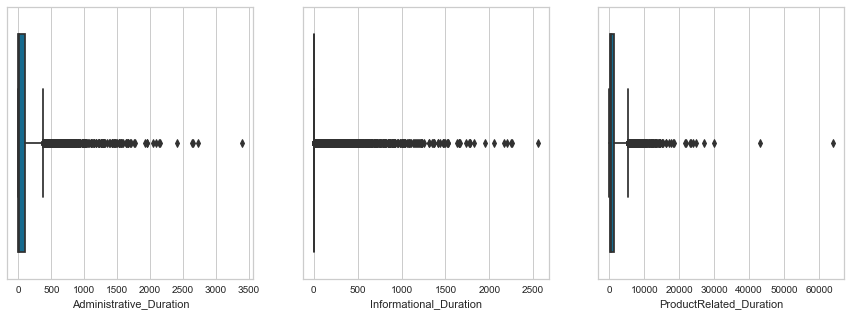

In [10]:
# Plot boxplots of num_values
plt.figure(figsize=(15, 5))

for i, num in enumerate(transform):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[num], whis=3)
    
plt.show()

#### Chart Analysis
The three charts above show two key points. First, the distribution of the data is positively skewed. Second, there are several points that are true outliers and should be removed. One example is the rightmost point in 'Product Related Duration'. This point indicates someone spent over 60k seconds looking at a single product. 60k seconds equates to about 17 hours, which is highly unlikely. It is far more likely the user left the webpage open in the background of his or her computer. 

## Dealing with Outliers
The first step of our data cleanup will be to remove all data points above three standard deviations. These data points represent less than five percent of the population. This will not significantly affect the results of the model. After the outliers are removed, the remaining data will be long transformed. This will eliminate the positive skew of the data.

In [11]:
# Remove ouliers from dataframe
for col in df[transform]:
    z = np.abs(stats.zscore(df[col]))
    row = []
    for i, x in enumerate(z):
        if x >= 3:
            row.append(i)        
    df.drop(row, axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)

# Log transform the data
for x in transform:
    df[x] = np.log1p(df[x])

# Print number of outliers
num_outliers(transform, threshold)

Number of Outliers per Column
Administrative_Duration: 0
Informational_Duration: 280
ProductRelated_Duration: 0


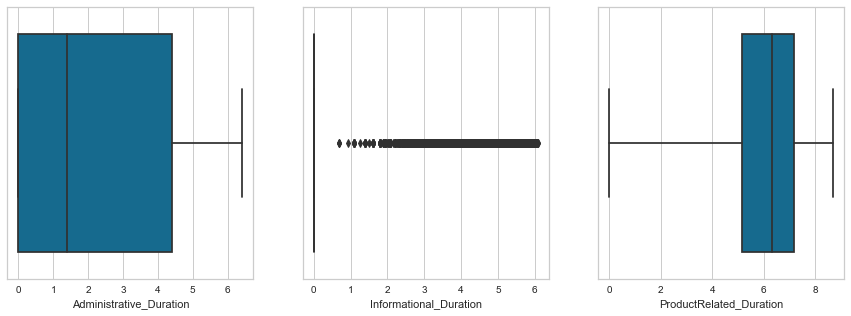

In [12]:
# Plot boxplots of num_values
plt.figure(figsize=(15, 5))

for i, num in enumerate(transform):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[num], whis=3)
    
plt.show()

# Data Exploration
The main variable that will be explored is revenue, and the correlation of the other variables with it. The following questions will be answered in the data exploration:
    1. What are the number of sales? Sale per visit rate? 
    2. Do sales increase on weekend? special days? month?
    3. How do page types affect sales? duration? bounce/exit rates? page values?
    4. What regions have the best sale rates?
    5. What are the sales demographics based on user type?    

In [13]:
def countbar_total(graph, x):
    """Add count to each bar in countplot
    
    Parameters
    graph: input the chart
    x(variable): x variable for chart"""
    
    for i, p in enumerate(graph.patches):
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height*1.01,
            x.value_counts()[i], ha="center")

## Overall Sales Rate and Weekends
The bar charts below show that only 14.71 percent of visits convert to sales. Most visits occur on the weekdays, but there are more sales as a percentage of visits on the weekend at 16.78 percent.

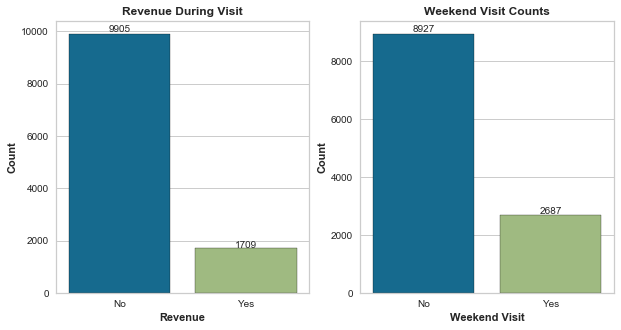

In [14]:
# Plot countplots of revenue and weekend
plt.figure(figsize=(10, 5))

plt.subplot(121)
graph = sns.countplot(x=df['Revenue'], edgecolor='black')

# Add countbar total for each bar
countbar_total(graph, df['Revenue'])

plt.title('Revenue During Visit', fontweight='bold')
plt.xlabel('Revenue', fontweight='bold')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Count', fontweight='bold')

plt.subplot(122)
graph = sns.countplot(x=df['Weekend'], edgecolor='black')

# Add countbar total for each bar
countbar_total(graph, df['Weekend'])

plt.title('Weekend Visit Counts', fontweight='bold')
plt.xlabel('Weekend Visit', fontweight='bold')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Count', fontweight='bold')

plt.show()

In [15]:
# Calculate number and percentage of sales per visitor
sales = df['Revenue'].value_counts()
visits = sales.sum()
convert = round(sales[1]/visits, 4)

print('Sale during visit:\n', sales)
print('\nPercentage of visits that convert to sales: {}%'.format(convert*100))

# Calculate number and percentage of sales on time of week
weekend = df['Weekend'].value_counts()
visits = weekend.sum()
convert = round(weekend[1]/visits, 4)

print('\nWeekend visits:\n', weekend)
print('\nPercentage of visits that are on weekend: {}%'.format(convert*100))
print('Percentage of weekend dates per week: {}%'.format(round((2/7*100),2)))

Sale during visit:
 False    9905
True     1709
Name: Revenue, dtype: int64

Percentage of visits that convert to sales: 14.71%

Weekend visits:
 False    8927
True     2687
Name: Weekend, dtype: int64

Percentage of visits that are on weekend: 23.14%
Percentage of weekend dates per week: 28.57%


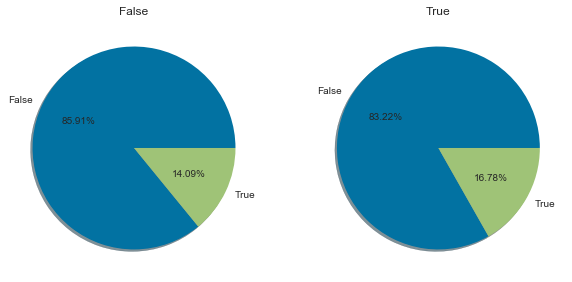

In [16]:
# Plot pie chart for conversions on weekends or weekdays
plt.figure(figsize=(10, 5))

visit = df['Weekend'].unique()

for i, x in enumerate(visit):
    i += 1
    plt.subplot(1, 2, i)
    
    # Create dataframe for each user type
    user = df[df['Weekend']==x]
    user = user['Revenue'].value_counts()

    plt.pie(user, labels=user.index, autopct='%1.2f%%', shadow=True, 
            pctdistance=.6, labeldistance=1.1)
    
    plt.title('{}'.format(x))

plt.show()

## Month Sales Exploration
The months with the highest sales were May, November, March, and December. While May had the most sales at 3200, November had more sales per visit. The sales conversion rate was 23.44 percent, which is significantly higher than the overall 14.71 percent conversion rate. One simple reason for higher sales in November could be the upcoming holiday season. As a result of the holidays, users on the website had a higher propensity to spend when they visited in November versus other times of year. We will understand why November had better sales below by exploring more features. In the chart below, false indicates a no sale visit, while true indicates a sale occurred.

In [17]:
# Create list of feature column names
col = list(df.columns)
col.remove('Revenue')

# List of all continuous variables
continuous = col[1:9]
continuous.remove('Informational')

# List of all categorical
categorical = col
for x in continuous:
    categorical.remove(x)

In [18]:
# Print list of highest conversion months
month_counts = df['Month'].value_counts()
print('Counts of variables per month:')
print(month_counts.sort_values(ascending=False))

Counts of variables per month:
May     3233
Nov     2700
Mar     1829
Dec     1649
Oct      521
Sep      418
Jul      407
Aug      404
June     271
Feb      182
Name: Month, dtype: int64


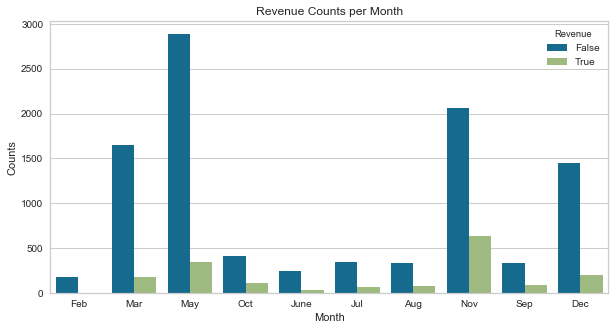

In [19]:
# Plot revenue conversion per month
plt.figure(figsize=(10, 5))

sns.countplot(x=df['Month'], hue=df['Revenue'])
plt.title('Revenue Counts per Month')
plt.ylabel('Counts')
plt.xlabel('Month')
plt.show()

In [20]:
# Calculate number and percentage of sales in November
month = df[df['Month']=='Nov']

sales = month['Revenue'].value_counts()
visits = sales.sum()
convert = round(sales[1]/visits, 4)

print('Sale during November:\n', sales)
print('\nPercentage of visits in November that convert to sales: {}%'.format(convert*100))

Sale during November:
 False    2067
True      633
Name: Revenue, dtype: int64

Percentage of visits in November that convert to sales: 23.44%


## Region Sales Exploration
The region with the highest number of visitors was region 1. Furthermore, region 1 had the highest sales. However, region three had the highest conversion rate. How do the November regoinal sales compare to overall regional sales? November had the same spread of visitors by region as the overall chart. The key difference was higher conversion in each category. Because the spread by region is the same on a monthly or annual basis, in general management could target region 1 conversion more heavily, as it has the highest number of visitors but a lower conversion rate. Alternatively, management could try to increase users from region 3 due to its high conversion rate.

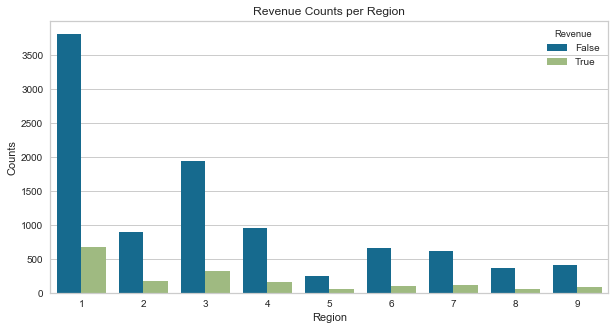

In [21]:
# Plot revenue count per region
plt.figure(figsize=(10, 5))

sns.countplot(x=df['Region'], hue=df['Revenue'])
plt.title('Revenue Counts per Region')
plt.ylabel('Counts')
plt.xlabel('Region')
plt.show()

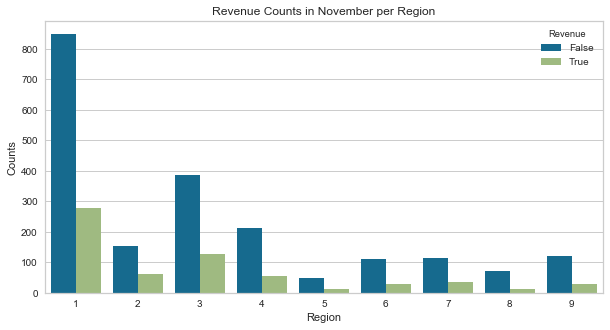

In [22]:
# Plot Revenue count in november per region
plt.figure(figsize=(10, 5))

sns.countplot(x=month['Region'], hue=month['Revenue'])
plt.title('Revenue Counts in November per Region')
plt.ylabel('Counts')
plt.xlabel('Region')
plt.show()

## Special Days Sales Exploration
This categorical variable had the most surprising results. Unique website visitors decreased as the holidays approached. Even worse, the conversion rate decreased from 15.7 percent overall to only 6.2 percent on a special day. November had no special days, which could be an indicator of why it had a higher conversion rate relative to other months. 

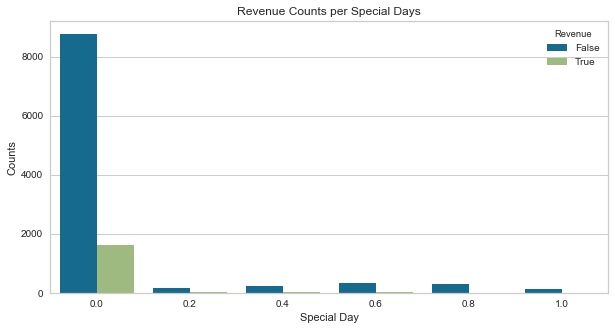

In [23]:
# Plot revenue counts per special day
plt.figure(figsize=(10, 5))

sns.countplot(x=df['SpecialDay'], hue=df['Revenue'])
plt.title('Revenue Counts per Special Days')
plt.ylabel('Counts')
plt.xlabel('Special Day')
plt.show()

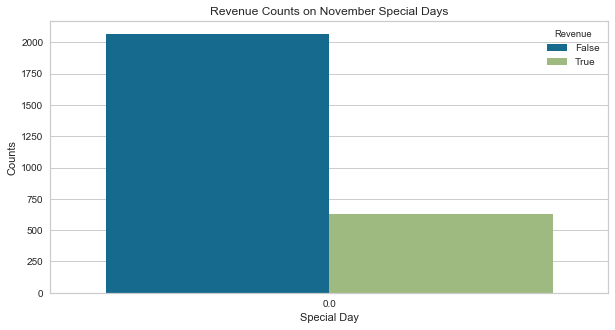

In [24]:
# Plot conversions in november special days
plt.figure(figsize=(10, 5))

sns.countplot(x=month['SpecialDay'], hue=month['Revenue'])
plt.title('Revenue Counts on November Normal Day')
plt.ylabel('Counts')
plt.xlabel('Special Day')
plt.show()

In [25]:
# Print number of special days
print('Counts of Special Days by Type')
print(df['SpecialDay'].value_counts())

# Calculate the number and percentage of conversions on special days
special = df[df['SpecialDay']>0]
not_special = df[df['SpecialDay']==0]

sales = special['Revenue'].value_counts()
visits = sales.sum()
convert = round(sales[1]/visits, 4)

print('\nSale during Special Days:\n', sales)
print('\nPercentage of visits during Special Days ',
      'that convert to sales: {}%'.format(convert*100))

# Calculate the number and percentage of conversions on normal days
sales = not_special['Revenue'].value_counts()
visits = sales.sum()
convert = round(sales[1]/visits, 4)

print('\nSale during Normal Days:\n', sales)
print('\nPercentage of visits during Normal Days ',
      'that convert to sales: {}%'.format(convert*100))

Counts of Special Days by Type
0.0    10401
0.6      343
0.8      314
0.4      235
0.2      172
1.0      149
Name: SpecialDay, dtype: int64

Sale during Special Days:
 False    1138
True       75
Name: Revenue, dtype: int64

Percentage of visits during Special Days that convert to sales: 6.18%

Sale during Normal Days:
 False    8767
True     1634
Name: Revenue, dtype: int64

Percentage of visits during Normal Days that convert to sales: 15.709999999999999%


## Visitor Type
There are three main visitor types for the website: Returning, New, and Other. Returning visitors are the largest group, representing 85 percent of the population, followed by new visitors at 14.23 percent. In terms of sales, returning visitors only generated revenue 13.03 percent of the time. New visitors were most likely to generate revenue at 24.62 percent. There must be a clear reason for this distinction. Perhaps the new visitors received a first-time discount, or entered the website after a positive ad. 

The 'Visitor Type vs Exit Rate' violin plot sheds some light on this question. The new visitors on average had lower exit rates than the returning visitors. Additionally, November, had a large number of new visitors in comparison to the other months, contributing to the higher conversion rate observed in November.

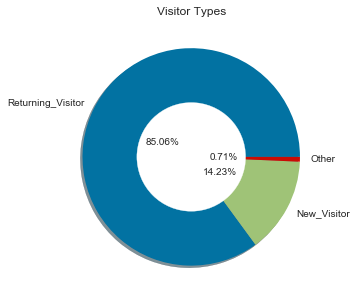

In [26]:
#  plot pie chart of visitor types
# Create a circle for the center of the plot
plt.figure(figsize=(10, 5))
my_circle=plt.Circle((0, 0), 0.5, color='white')
user = df['VisitorType'].value_counts()

plt.pie(user, labels=user.index, autopct='%1.2f%%', shadow=True, 
        pctdistance=.3, labeldistance=1.1)
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title('Visitor Types')
plt.show()

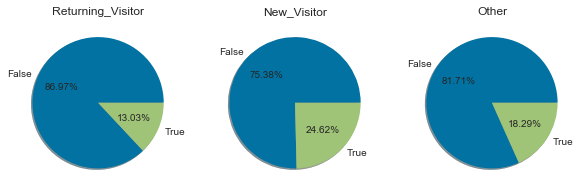

In [27]:
# Plot pie charts for revenue by visitor type
plt.figure(figsize=(10, 5))

visit = df['VisitorType'].unique()

for i, x in enumerate(visit):
    plt.subplot(1, 3, i+1)
    
    # Create dataframe for each user type
    user = df[df['VisitorType']==x]
    user = user['Revenue'].value_counts()

    plt.pie(user, labels=user.index, autopct='%1.2f%%', shadow=True, 
            pctdistance=.6, labeldistance=1.1)
    
    plt.title('{}'.format(x))

plt.show()

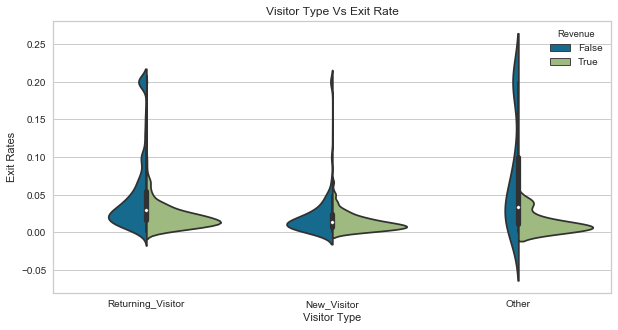

In [28]:
# Plot violin plot of visitor type vs exit rate by revenue type
plt.figure(figsize=(10, 5))
sns.violinplot(x=df['VisitorType'], y=df['ExitRates'], 
               hue=df['Revenue'], split=True)

plt.title('Visitor Type Vs Exit Rate')
plt.xlabel('Visitor Type')
plt.ylabel('Exit Rates')

plt.show()

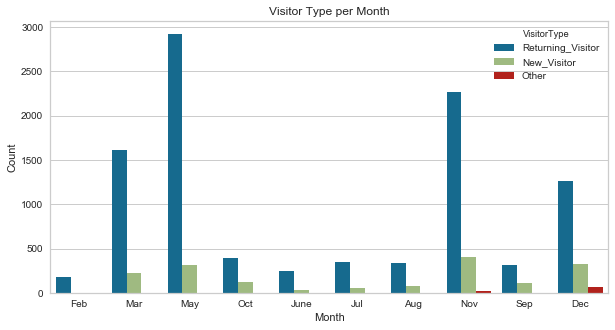

In [29]:
# Plot clustered bar chart of visitor type per month
plt.figure(figsize=(10, 5))
sns.countplot(x=df['Month'], hue=df['VisitorType'])

plt.title('Visitor Type per Month')
plt.xlabel('Month')
plt.ylabel('Count')

plt.show()

## Webpage Type, Bounce/Exit Rates, and Page Value
Most of the distribution of the data points for webpage type falls within the first several groups, as shown by the violin plots. This suggests the first categories are the most informative webpages. In terms of duration, visitors spent the most time on product related pages. Very little time was spent on the information pages, and a moderate amount of time was spent on the administrative page. The bounce and exit rates range from 0 to .2. The rates for most users are below .05 meaning that users go through several webpages on the site before exiting. Lastly, most days when conversion occurs are not special days, indicating that most conversions occur on a non-holiday day. 

The scatter plots below show interesting trends for several variables relative to revenue generation. First, there was no clear correlation between the type of webpage and revenue. The product duration had a clear correlation; where the longer a user spent on the website, the more likely it ws that revenue would be generated. As expected, bounce rates and exit rates had a negative correlation with revenue. The lower the rate, the higher the likelihood of conversion. Lastly, the higher the page value the greater chance of conversion on that page.

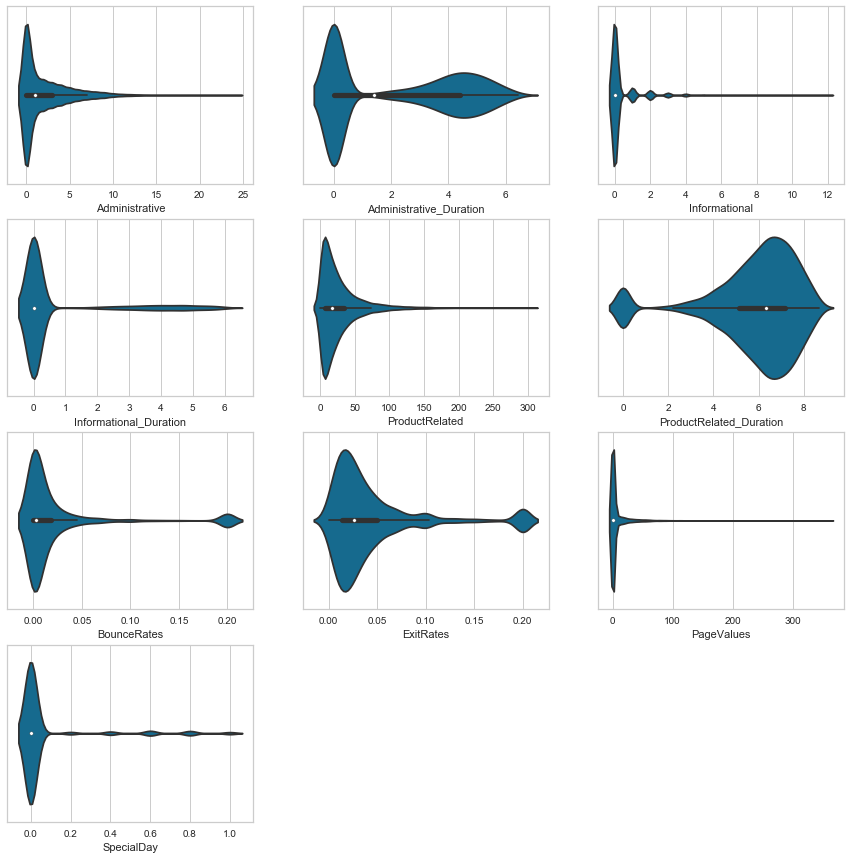

In [30]:
# Plot violin points of num_values
plt.figure(figsize=(15, 15))

for i, num in enumerate(num_values):
    plt.subplot(4, 3, i+1)
    sns.violinplot(x=df[num])
    
plt.show()

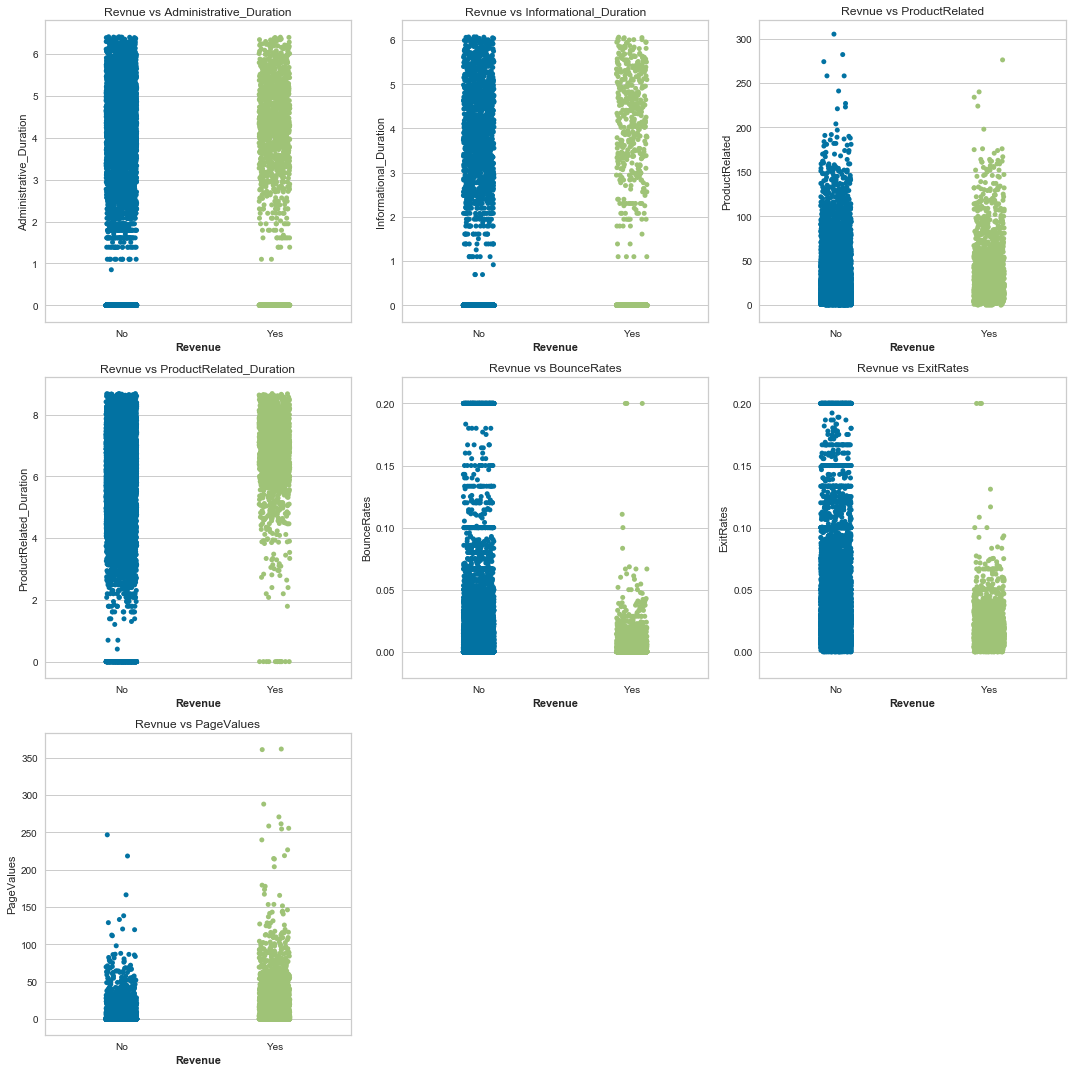

In [31]:
# Plot stripplot for each feature against revenue
plt.figure(figsize=(15, 15))

for i, x in enumerate(continuous):
    plt.subplot(3, 3, i+1)

    sns.stripplot(x=df['Revenue'], y=df[x])
    
    plt.title('Revnue vs {}'.format(x))
    plt.ylabel('{}'.format(x))
    plt.xlabel('Revenue', fontweight='bold')
    plt.xticks([0, 1], ['No', 'Yes'])
    
plt.tight_layout()    
plt.show()

# Correlations
The correlations of each variable are plotted in the heatmap below. The highlights of the heatmap are listed below:
    1. Bounce Rates and Exit Rates are .91 correlated, which indicative that the bounce rate of a page is included in the calculation of the exit rate.
    2. Bounce Rates and Exit Rates have a strong negative correlation relative to product duration. Meaning that most users spend very little time on product pages before exiting the website. 
    3. Admin, Info, and Product pages were all highly correlated to their perspective duration variable. 
    4. Page value was the most correlated item to Revenue, which agrees to the conclusions from the chart above. 
    5. Exit rate is the most negative correlated variable to Revenue.
    
### Drop Variables
The strong correlation of bounce rates and exit rates indicate that these variables are near identical. Inclusion of both variables will create noise in the model. As such, bounce rates will be dropped as this variable less correlated to revenue.

In [32]:
# Convert objects to integers
objects = df.select_dtypes(include='object')

for obj in objects:
    temp = {i: j for j, i in enumerate(set(df[obj]))} 
    res = [temp[i] for i in df[obj]] 
    df[obj] = list(res)

# Convert boolean column to 0 for false, 1 for true
bools = df[df.columns[-2:]]

for x in bools:
    df[x] = df[x].astype(int)

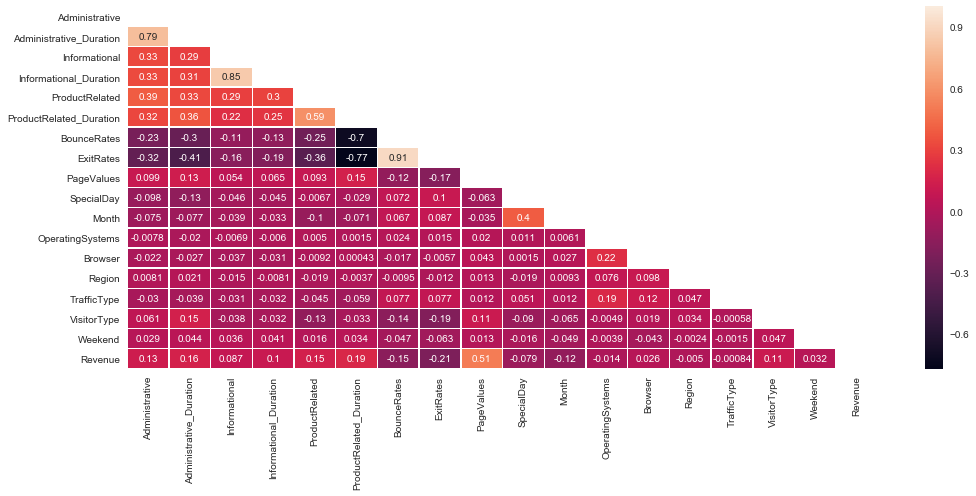

In [33]:
# plot correlation heatmap
df_cor = normalize(df)
df_corr = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 7))

# Clean up the heatmap and remove repeat values
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

# PLot the heatmap of the correlations
sns.heatmap(df_corr, annot=True, linewidths=.5, mask=mask)
plt.tight_layout()
plt.show()

In [34]:
# Print the correlations of Revenue
print(df_corr['Revenue'].sort_values(ascending=False))

Revenue                    1.000000
PageValues                 0.509269
ProductRelated_Duration    0.188704
Administrative_Duration    0.157775
ProductRelated             0.151184
Administrative             0.126436
VisitorType                0.114592
Informational_Duration     0.102055
Informational              0.086574
Weekend                    0.032050
Browser                    0.026332
TrafficType               -0.000844
Region                    -0.005023
OperatingSystems          -0.013689
SpecialDay                -0.078732
Month                     -0.115251
BounceRates               -0.149817
ExitRates                 -0.205427
Name: Revenue, dtype: float64


## Clustering
The highest correlated features to revenue conversion i.e. page value and exit rate will be clustered together to find similar groups within the data set.

## K-Means
The first clustering method that will be used is the K-Means. K-Means clustering is an unsupervised machine learning algorithm that attempts to classify data without having been trained with labeled data. Data points are grouped by a pre-determined number of clusters. To find the ideal number of clusters an elbow chart was used. The elbow chart is a chart of the sum of squared errors for each cluster. The ideal number of clusters occurs when the next cluster results in diminishing returns. The elbow chart below shows that the ideal number of clusters in this dataset is 6. Unfortunately, the k-mean chart of page value and exit rate did not form any informative clusters.

In [35]:
# Standardize the target variables
features = df.drop('Revenue', axis=1)
X = StandardScaler().fit_transform(features)

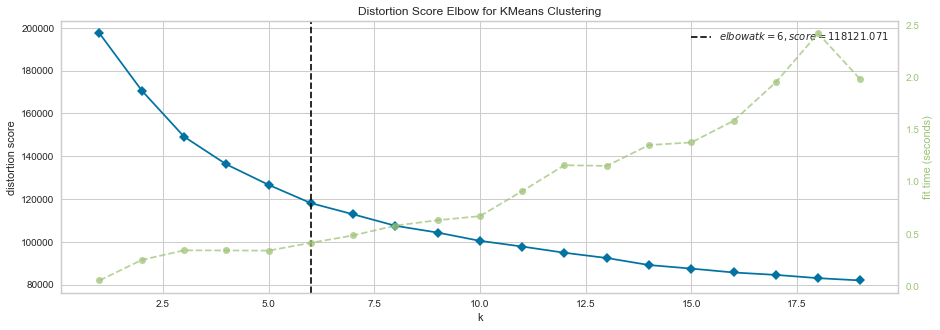

In [36]:
km = KMeans()

plt.figure(figsize=(15, 5))

# Find the optimal number of clusters for KMeans
vis = KElbowVisualizer(km, k=(1,20))
vis.fit(X)
vis.poof()
n = vis.elbow_value_

plt.show()

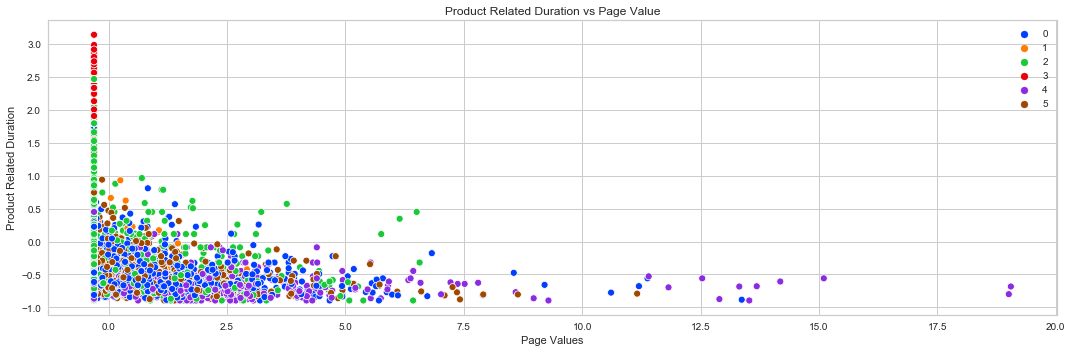

In [37]:
# Plot K-Means Clusters
plt.figure(figsize=(15, 5))

model = KMeans(n_clusters=n).fit_predict(X)
pal = sns.color_palette('bright', n)
sns.scatterplot(x=X[:,8], y=X[:,7], hue=model, palette=pal)
plt.ylabel('Product Related Duration')
plt.xlabel('Page Values')
plt.title('Product Related Duration vs Page Value')

plt.tight_layout()
plt.show()

## Agglomerative Clustering
Agglomerative clustering is a form of hierarchical clustering. It uses a bottom up approach; start with many small clusters and merge them together to create bigger clusters. This assumes no number of clusters unlike k-means but once two clusters are merged it can't be undone. A dendrogram is a visual history of grouping. It will be used to find the optimal number of clusters using the following criteria:
    1. The largest vertical distance that doesn’t intersect any of the other clusters
    2. A horizontal line at both extremities of the largest distance
    3. The optimal number of clusters is equal to the number of vertical lines going through the horizontal line
In our dendrogram the ideal number of clusters is 3. Each datapoint is linked via ward linkage. Ward linkage is the sum of squared differences within all clusters. The last parameter of our clustering model is the affinity or distance metric. Euclidean method choses the shortest distance between two points.

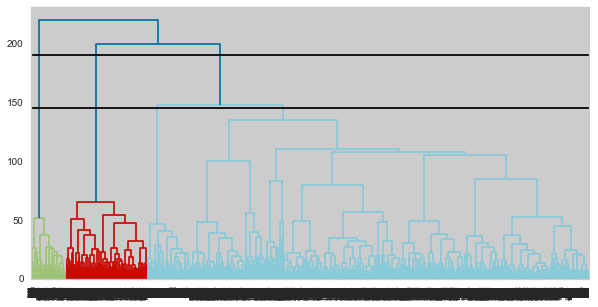

In [38]:
# Chart dendrogram and select ideal number of clusters
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.axhline(y=145, color='black')
plt.axhline(y=190, color='black')
plt.show()

In [39]:
# Fit agglomerative clustering model
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_

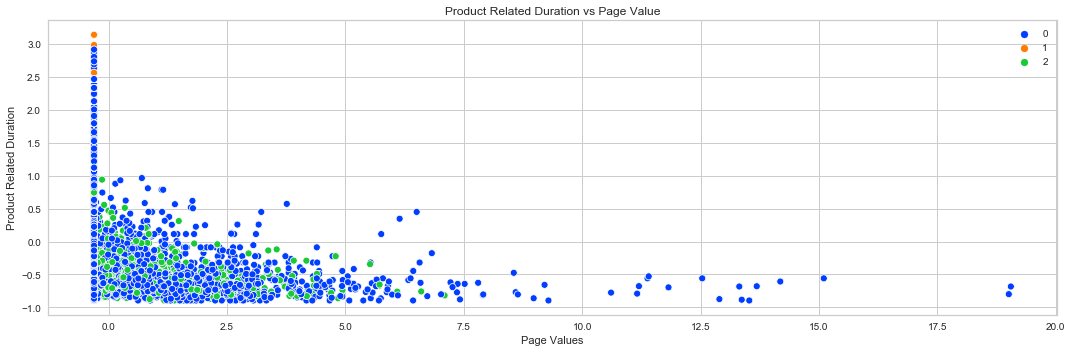

In [40]:
# Plot agglomerative clusters
plt.figure(figsize=(15, 5))

pal = sns.color_palette('bright', 3)
sns.scatterplot(x=X[:,8], y=X[:,7], hue=labels, palette=pal)
plt.ylabel('Product Related Duration')
plt.xlabel('Page Values')
plt.title('Product Related Duration vs Page Value')

plt.tight_layout()
plt.show()

### Agglomerative Clustering Results
Unfortunately, like the K-Means clustering the agglomerative clusters did not produce any informative groups. There is too much noise in the data, and a PCA will be utilized to reduce the noise. 

# PCA
Principal Component Analysis (PCA) is a great tool to reduce the dimensions of features. One can explain a large portion of the variance within dataset by reducing the dimensions. The first step is to make sure that all the features within the PCA are somewhat correlated to the target variable. In this case all variables that are correlated by minimum of .1 or -.1 will be included in the PCA. Furthermore, as identified above bounce rates will be dropped as it is highly correlated to the exit rate. The goal here is to reduce bias and noise. 

The next step is to calculate the eigen values and eigen vectors. Eigen values represent magnitude and importance. Only eigen values with a value above 1 will be selected as a PCA component. Eigen vectors represent the directions that the data is dispersed. In the case of the website dataset the ideal number of PCA components is 3. These 3 components represent 60.7% of the data.

In [41]:
# Create a list of column names with correlations 
# above and below .1 for PCA
pca_col = []
tmp = np.abs(df_corr['Revenue'])
tmp = tmp>.1
tmp = pd.DataFrame(tmp)
tmp.reset_index(inplace=True)

for i, x in enumerate(tmp['Revenue']):
    if x == 1:
        pca_col.append(tmp.loc[i, 'index'])

# Remove Revenue
pca_col.remove('Revenue')
pca_col.remove('BounceRates')
print(pca_col)

['Administrative', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'PageValues', 'Month', 'VisitorType']


In [42]:
features = df[pca_col]
X = StandardScaler().fit_transform(features)

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculate the eigenvalues and eigenvectors
eig_val, eig_vec = np.linalg.eig(Cx)

# Return number of components above 1
components = 0
for x in eig_val:
    if x > 1:
        components += 1

print('Number of Components: {}'.format(components))

# All components above 1 selected for PCA
pca = PCA(n_components=components)
X_pca = pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by the total',
    'components from Sklearn PCA.\n',
    pca.explained_variance_ratio_.sum())

pca_df = pd.DataFrame(data=X_pca)

Number of Components: 3
The percentage of total variance in the dataset explained by the total components from Sklearn PCA.
 0.6073833418231825


In [43]:
final_df = pd.concat([pca_df, df['Revenue']], axis=1)
final_df.head()

,0,1,2,Revenue
0,-3.997558,-0.296199,-2.155927,0
1,-2.196280,-0.531309,-0.367708,0
2,-2.143013,-0.726911,-1.151473,0
3,-3.182339,-0.322716,-1.345517,0
4,-1.156059,-0.759096,0.595364,0


The PCA components were added to the target variable 'Revenue' to create the modeling dataset. 

## PCA K-Means Cluster
The ideal number of clusters identified by the elbow plot was 5. The first two PCA components were plotted as they represented the largest amount of the variance.

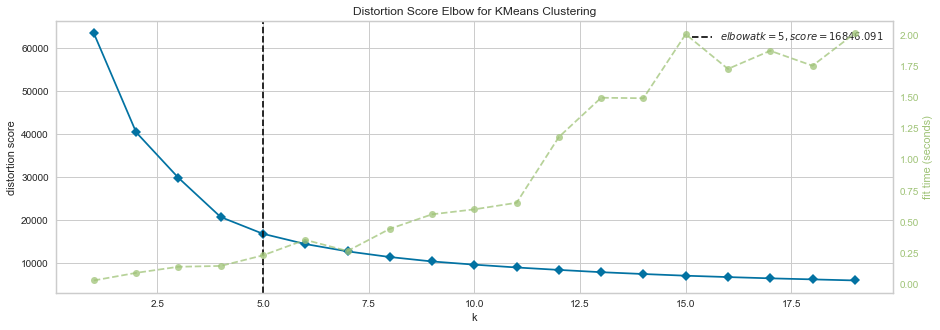

In [44]:
km = KMeans()

plt.figure(figsize=(15, 5))

# Find the optimal number of clusters for KMeans
vis = KElbowVisualizer(km, k=(1,20))
vis.fit(X_pca)
vis.poof()
n = vis.elbow_value_

plt.show()

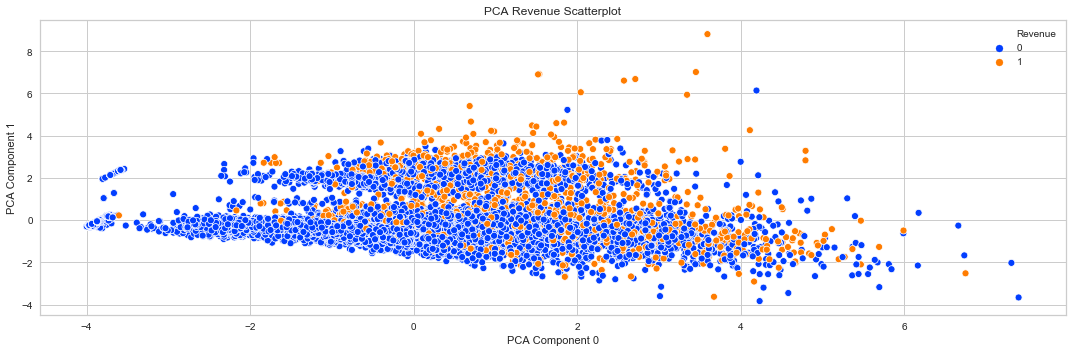

In [45]:
# Plot the revenue conversion clusters
plt.figure(figsize=(15, 5))
pal = sns.color_palette('bright', 2)
sns.scatterplot(x=final_df[0], y=final_df[1], hue=final_df['Revenue'], palette=pal)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('PCA Revenue Scatterplot')

plt.tight_layout()
plt.show()

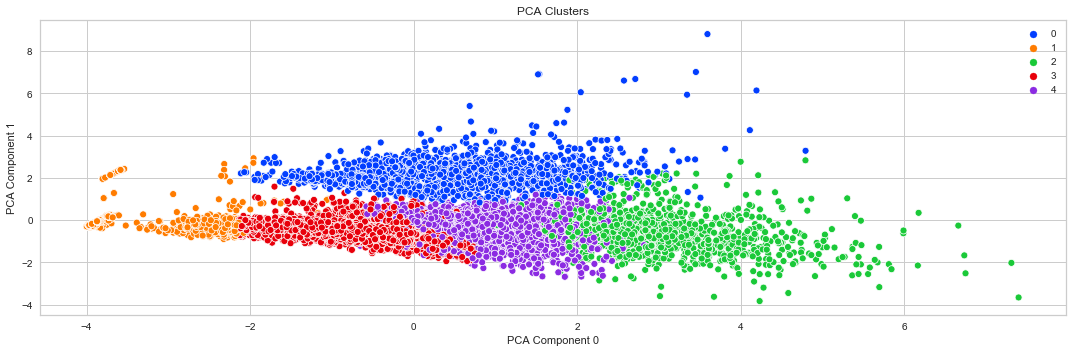

In [46]:
# Plot K-Means of pca components
plt.figure(figsize=(15, 5))

km = KMeans(n_clusters=n).fit_predict(X_pca)
pal = sns.color_palette('bright', n)
sns.scatterplot(x=final_df[0], y=final_df[1], hue=km, palette=pal)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('PCA Clusters')

plt.tight_layout()
plt.show()

### K - Means Analysis
The PCA K-Means chart is a massive improvement from the non-PCA charts. There are 5 distinctive group identified above. These five groups could be identified as users of the website. Judging by the PCA revenue scatterplot and the PCA clusters below, cluster number 3 could represent the sales group as it has the largest number sales. Let’s assess the proportion of each feature to its PCA component below.

## PCA Component Heatmap
Components 0 and 1 have the largest variance of the dataset. The main features of PCA 0 are admin, admin duration, product related duration and exit rates. For PCA 1 the main features are page values and visitor type.

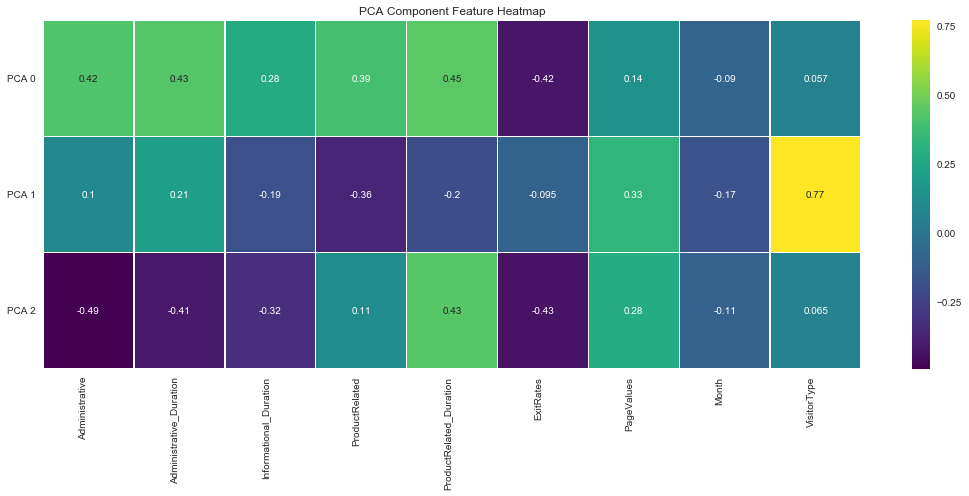

In [65]:
plt.figure(figsize=(15, 7))
sns.heatmap(pca.components_,cmap='viridis', annot=True, linewidths=.5)

# Add pca components to rows
plt.yticks(np.arange(3),['PCA 0','PCA 1', 'PCA 2'],
           fontsize=10, rotation='horizontal', va='center')

# Add feaute names to columns
plt.xticks(range(len(features.columns)),features.columns, rotation='vertical',ha='right')

# Adjust the x and y labels
ax = plt.gca()
ax.set_xticks(np.arange(.5, 9, 1))
ax.set_yticks(np.arange(.5, 3, 1))

plt.title('PCA Component Feature Heatmap')
plt.tight_layout()
plt.show()

# Neural Network - Keras
The business case of this project is to determine if one can reliably predict sales based on website metrics. In the sections above, the best features were transposed to create several PCA components. These components will be utilized below to create a model to predict if a user will produce revenue. Keras will be utilized to build a neural network to predict revenue. Keras is a high-level API built on TensorFlow. It is more user-friendly and easier to use in comparison to TensorFlow. 

## Model 1: Baseline
Model 1 will be a baseline of the accuracy of the neural network for all future models. For model 1 a classical feed-forward neural network will be built. In a feed-forward neural network, information flows from the input layers, through the hidden layers, and ultimately an output. There are no connects in this neural network that fed back into itself. Several key parameters were chosen.

#### Activation Function
The activation function is responsible for transforming the weighted input into the node. Rectified linear unit (RELU) was chosen as the activation function. RELU is a nonlinear function that allows complex relationships to be learned. It provides sensitivity to the activation sum and avoids saturation by outputting the input directly if positive otherwise it will output zero. This means that the neural network will have computational simplicity, representation sparsity (capable of outputting zero), linear behavior, and train deep networks.

#### Optimizer
The optimizer algorithm chosen is Adam. Adam is a method for efficient stochastic optimization. The method computes individual adaptive learning rates for different parameters from estimates. It combines the advantages of AdaGrad and RMSProp. This leads to several advantages:
    1. Straightforward to implement
    2. Computationally efficient
    3. Little memory requirements
    4. Invariant to diagonal rescale of the gradients
    5. Hyper-parameters have intuitive interpretation and typically require little tuning
    
#### Loss Function
The loss function is straightforward. The target variable is Boolean as such binary cross entropy was chosen. It sets up a binary classification problem between each class and is not affect by other components values.

In [54]:
# X is the pca features
X = final_df.drop(final_df['Revenue'], axis=1)

# y is the target variable
y = final_df['Revenue']

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [55]:
classifier = Sequential()

#First Hidden Layer
classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal', input_dim=2))

#Second  Hidden Layer
classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal'))

#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
classifier.compile(optimizer='adam',loss='binary_crossentropy', metrics =['accuracy'])

#Fitting the data to the training dataset
history = classifier.fit(X_train, y_train, validation_split = 0.05, epochs=50, batch_size=10)

Train on 8826 samples, validate on 465 samples
Epoch 1/50
8826/8826 [==============================] - 1s 103us/step - loss: 0.4164 - accuracy: 0.8530 - val_loss: 0.2092 - val_accuracy: 0.8172
Epoch 2/50
8826/8826 [==============================] - 1s 92us/step - loss: 0.1363 - accuracy: 0.8530 - val_loss: 0.1331 - val_accuracy: 0.8172
Epoch 3/50
8826/8826 [==============================] - 1s 95us/step - loss: 0.0897 - accuracy: 0.9997 - val_loss: 0.0903 - val_accuracy: 1.0000
Epoch 4/50
8826/8826 [==============================] - 1s 98us/step - loss: 0.0604 - accuracy: 1.0000 - val_loss: 0.0609 - val_accuracy: 1.0000
Epoch 5/50
8826/8826 [==============================] - 1s 97us/step - loss: 0.0406 - accuracy: 1.0000 - val_loss: 0.0410 - val_accuracy: 1.0000
Epoch 6/50
8826/8826 [==============================] - 1s 93us/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 7/50
8826/8826 [==============================] - 1s 93us/step - loss: 0.018

In [56]:
# Print History Keys for chart
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


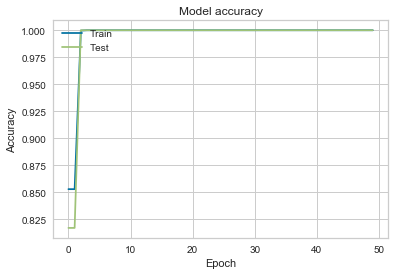

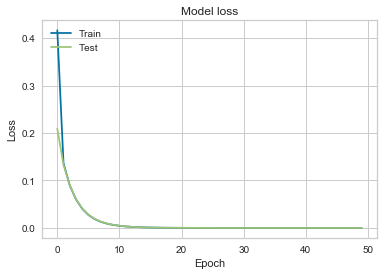

In [57]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Evaluating the Training and Validation Results
It was very surprising to see that after 50 epochs the training and validation set were both 100% accurate and the loss function still getting smaller. The accuracy and loss values have an inverse relationship with each other. The expectation with these charts was to find the point in which the validation set reversed to find the ideal number of epochs. 

In [58]:
# Evaluate training model
eval_model = classifier.evaluate(X_train, y_train)
eval_model

9291/9291 [==============================] - 0s 16us/step


[2.271493850001631e-08, 1.0]

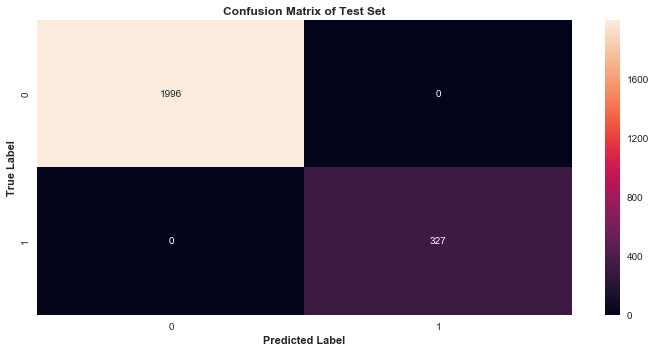

In [59]:
# Predict the test set
y_pred = classifier.predict(X_test)

#If the prediction is greater than 0.5 then the output 1, else 0
y_pred = (y_pred>0.5)

# create heatmap of confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary and Conclusion
There was no need to keep modeling after the results of model 1. Both the train and test sets had 100 percent accuracy. The biggest fear with 100 percent accuracy is that the model is overfitted. But the accuracy and loss charts disproved this as the validation set continued to have extremely low loss rates. Furthermore, the testing accuracy was perfect. This means that the model was able to correctly predict all visitor revenue from 20 percent of unseen data. This model could be used by a business to predict whether a visitor will produce revenue to a website. 

One example is that a marketing department could use this model to test target metrics of personas created. The data exploration of this website showed distinct groups within the data. A marketing department should understand and consider the demographics of each of these groups. Once personas for these group are created, marketing could test metrics within each group that would generate an acceptable revenue conversion rate. 

Additionally, webpage bounce rate and exit rates could be analyzed further. The analysis could be used to improve, remove, or duplicate features from these pages. A/B testing would be a great tool to test any changes to these webpages to see if the changes yield better rates.

# References
Data - https://www.kaggle.com/roshansharma/online-shoppers-intention

Bounce vs Exit Rate - https://support.google.com/analytics/answer/2525491?hl=en

Page Value - https://support.google.com/analytics/answer/2695658?hl=en

Adam - https://arxiv.org/abs/1412.6980